In [3]:
%load_ext autoreload
%autoreload 2
!RUST_BACKTRACE=1 cargo run -- ../models/msd.mo -t ../templates/casadi_dae.jinja > msd_ca.py

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
    Finished ]8;;https://doc.rust-lang.org/cargo/reference/profiles.html#default-profiles\`dev` profile [unoptimized + debuginfo]]8;;\ target(s) in 0.08s
     Running `/home/micah/Research/devlopment/rumoca/target/debug/rumoca ../models/msd.mo -t ../templates/casadi_dae.jinja`


In [31]:
!RUST_BACKTRACE=1 cargo run -- -v ../models/bouncing_ball2.mo > bouncing_ball2_json.json

    Finished ]8;;https://doc.rust-lang.org/cargo/reference/profiles.html#default-profiles\`dev` profile [unoptimized + debuginfo]]8;;\ target(s) in 0.06s
     Running `/home/micah/Research/parol/rumoca_parol/target/debug/rumoca -v ../models/bouncing_ball2.mo`


CasADi - 2025-05-09 10:48:17 WARNING("DaeBuilder::pre has not been implemented: Returning identity mapping") [.../casadi/core/dae_builder.cpp:769]


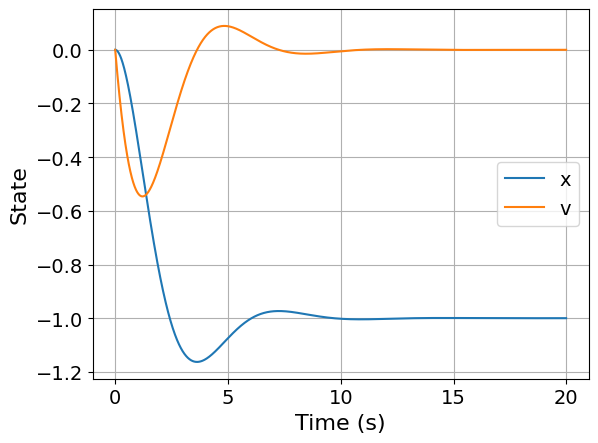

In [4]:
import msd_ca
import matplotlib.pyplot as plt
import casadi as ca
import numpy as np

model = msd_ca.Model("msd")

u = [1]
tgrid, res = model.simulate(t0=0, tf=20, dt=0.01, f_u=u)


plt.plot(tgrid, res['xf'].T, label=model.dae.x())

# Set axis label and tick font sizes
plt.xlabel("Time (s)", fontsize=16)
plt.ylabel("State", fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)

# Make legend font larger
plt.legend(fontsize=14)
plt.grid()

# Save without cutting off labels
plt.savefig("msd_casadi.pdf", bbox_inches='tight')

plt.show()

In [5]:
T = 10 # Duration of simulation
N = 20 # Number of steps in simulation.
# Step size is T/N
intg_options = dict(tf=T/N, simplify=True,number_of_finite_elements=4)
intg = ca.integrator('intg', 'rk', model.dae.create(), intg_options)
intg

CasADi - 2025-05-09 10:48:21 WARNING("The options 't0', 'tf', 'grid' and 'output_t0' have been deprecated.
The same functionality is provided by providing additional input arguments to the 'integrator' function, in particular:
 * Call integrator(..., t0, tf, options) for a single output time, or
 * Call integrator(..., t0, grid, options) for multiple grid points.
The legacy 'output_t0' option can be emulated by including or excluding 't0' in 'grid'.
Backwards compatibility is provided in this release only.") [.../casadi/core/integrator.cpp:692]


Function(intg:(x0[2],z0[0],p[3],u,adj_xf[],adj_zf[],adj_qf[])->(xf[2],zf[],qf[0],adj_x0[],adj_z0[],adj_p[],adj_u[]) MXFunction)

In [6]:
p = [1,1,1]
# States
x = ca.SX.sym('x',2)
# Controls
u = ca.SX.sym('u')
res = intg(x0=x,p=p, u=u)
x_next = res['xf']
F = ca.Function('F',[x,u],[x_next]) # Integrates one time step.
F

Function(F:(i0[2],i1)->(o0[2]) SXFunction)

Text(0, 0.5, 'Position')

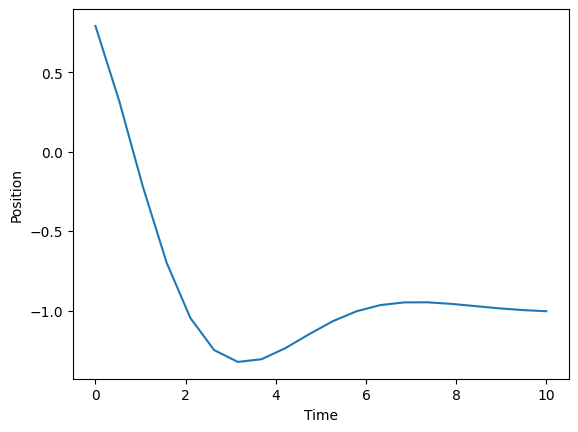

In [7]:
sim = F.mapaccum(N)
x0 = [1,0]
# Here, u = 1 for the duration of the simulation.
res = sim(x0,1)
resx1 = np.array(res[0,:]).flatten()

# print(resx1)
# print(res)
tgrid = np.linspace(0,T,N)
plt.plot(tgrid, resx1)
plt.xlabel("Time")
plt.ylabel("Position")

In [8]:
# Jacobian
U = ca.MX.sym('U',1,N)
X1 = sim(x0,U)[0,:]
J = ca.jacobian(X1,U)
Jf = ca.Function('F', [U], [J])

In [9]:
opti = ca.Opti()
# The state
x = opti.variable(2,N)
# The control input
u = opti.variable(1,N-1)
# This is just the initial state, x0
x0 = opti.parameter(2,1)

# Mazimize possible disturbance of positon
opti.minimize(-1*ca.sumsqr(x))

for k in range(N-1):
    opti.subject_to(x[:,k+1]==F(x[:,k],u[:,k]))

# The input is bounded between -1 and 1.
opti.subject_to(u<=1)
opti.subject_to(u>=-1)
opti.subject_to(x[:,0]==x0)
opti

Opti(Opti {
  instance #0
  #variables: 2 (nx = 59)
  #parameters: 1 (np = 2)
  #constraints: 22 (ng = 78)
  CasADi solver needs updating.
})

In [10]:
# opti.solver('sqpmethod', dict('qpsol': 'qrqp'))
p_opts = {"expand":True}
s_opts = {"max_iter": 100}
opti.solver("ipopt",p_opts,
                    s_opts)
opti.set_value(x0,[1,0]);
sol = opti.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      154
Number of nonzeros in inequality constraint Jacobian.:       38
Number of nonzeros in Lagrangian Hessian.............:       40

Total number of variables............................:       59
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       40
Total number of inequality c

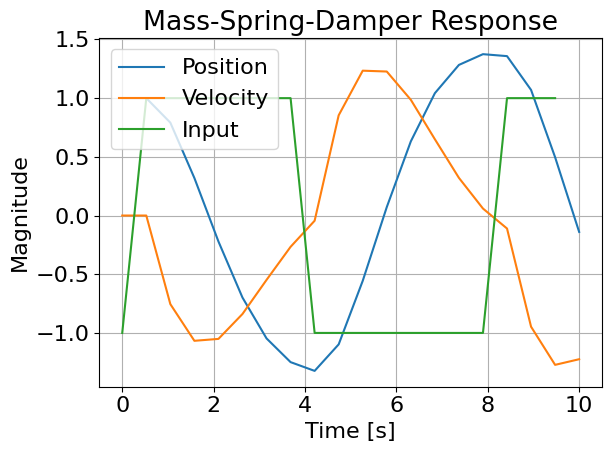

In [11]:
import matplotlib.pyplot as plt

# Set global font size to 16
plt.rcParams.update({'font.size': 16})

# Extract solutions
sol_x1 = sol.value(x)[0, :]
sol_x2 = sol.value(x)[1, :]
sol_u = sol.value(u)

# Plotting
plt.plot(tgrid, sol_x1, label="Position")
plt.plot(tgrid, sol_x2, label="Velocity")
plt.plot(tgrid[:-1], sol_u, label="Input")

plt.title("Mass-Spring-Damper Response")
plt.xlabel("Time [s]")
plt.ylabel("Magnitude")
plt.grid()

# Legend in top-left with opaque background
plt.legend(loc='upper left', frameon=True, facecolor='white')

plt.tight_layout()
plt.savefig("casadi_spring_opt.pdf")
plt.show()
